* 整理自链接： https://hrl.boyuai.com/chapter/2/dqn%E7%AE%97%E6%B3%95

&&  https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/

修改图片尺寸 (先把图片复制到该页面获取链接，复制链接，再视情况调整图片尺寸)：

`<img src="  " width="600">`

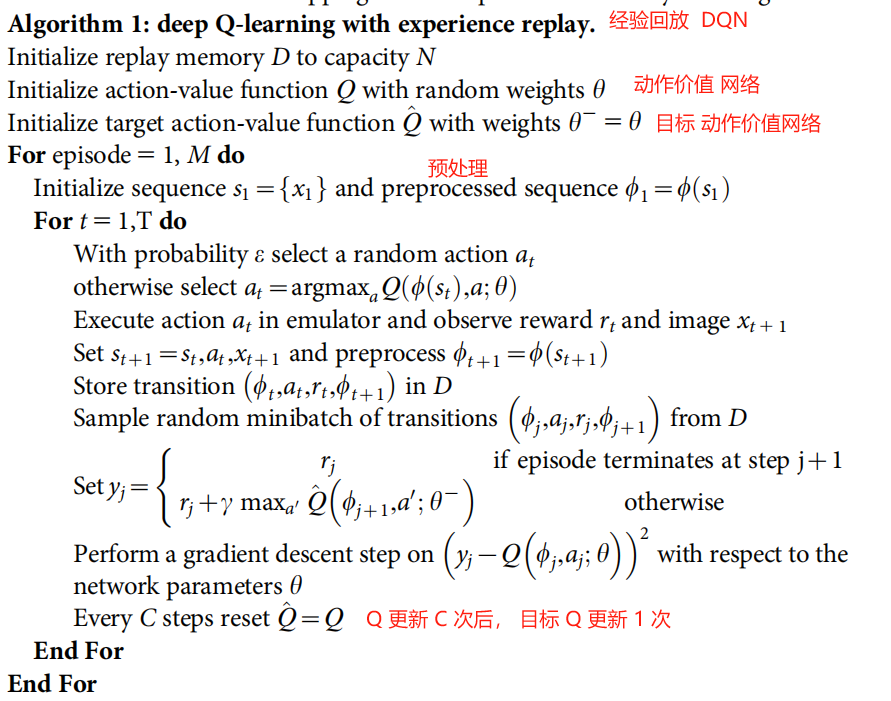

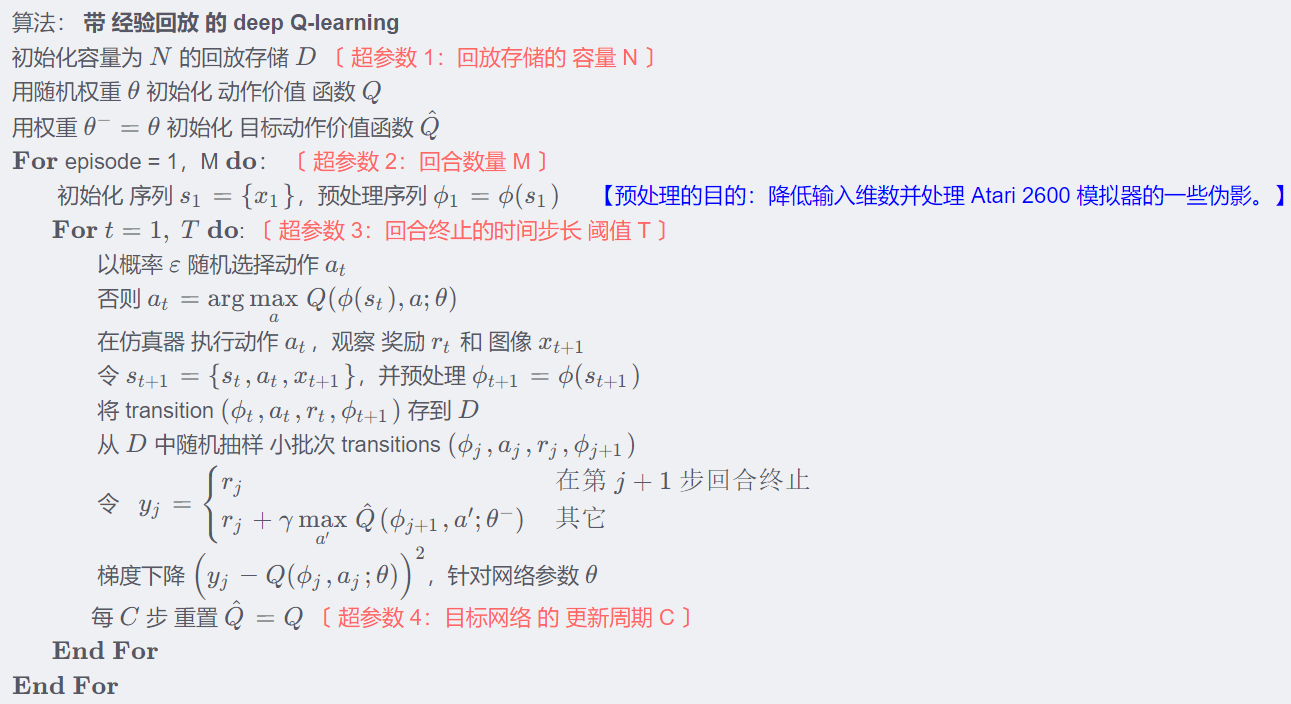

# Code

In [15]:
!pip install gymnasium

In [16]:
import gymnasium as gym
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 这样 无需 plt.show()  直接在代码单元下方显示图
from tqdm import tqdm
import random
import collections
# import rl_utils

# https://github.com/boyu-ai/Hands-on-RL/blob/main/rl_utils.py

import warnings   # 忽略警告
warnings.filterwarnings("ignore")

##   类模块

### 经验回放

* 加入数据
* 采样数据

In [17]:
class ReplayBuffer:
  """ 经验回放池"""
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)  # 队列，先进先出

  def add(self, state, action, reward, next_state, done): # 将 转换 加入 buffer
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size): # 从 buffer 中采样数据， 数量为 batch_size
    transitions = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*transitions)
    return np.array(state), action, reward, np.array(next_state), done

  def size(self): # 目前 buffer 中数据的数量
    return len(self.buffer)

### Q 网络 (一层隐藏层)

In [18]:
class Qnet(torch.nn.Module):
  """ 只有一层隐藏层 的 Q 网络"""

  def __init__(self, state_dim, hidden_dim, action_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim) # 全连接层
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # 隐藏层 使用 ReLU 激活函数
    return self.fc2(x)

### DQN 算法

In [19]:
class DQN:
  """ DQN 算法"""
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
    self.action_dim = action_dim
    # Q 网络
    self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
    # 目标网络
    self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
    # 使用 Adam 优化器
    self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
    self.gamma = gamma # 折扣因子
    self.epsilon = epsilon  # ε- greedy 策略的参数 (以 概率 ε随机选择动作， 以概率 1-ε执行动作价值最大的动作 )
    self.target_update = target_update  # 目标网络 更新频率
    self.count = 0 # 计数器，用于记录 在线网络 Q 的更新次数， 若是间隔达到 C 次，更新目标网络参数
    self.device = device

  def take_action(self, state): # 遵循 ε- greedy 策略 选取动作
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.action_dim)
    else:
      state = torch.tensor([state], dtype=torch.float).to(self.device)
      action = self.q_net(state).argmax().item()
    return action

  def update(self, transition_dict): # 每回合 更新一次
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device) # view(-1, 1) 数据维度修改为 1 列， 行数自适应
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

    q_values = self.q_net(states).gather(1, actions)  #  整合动作的价值
    # 下个状态的最大 动作价值 Q_max
    max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)  # # A.max(1)返回 A 每一行最大值组成的一维数组
    q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # r + γ max(s_{t+1}, a_{t+1})
    dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
    self.optimizer.zero_grad()  # 梯度重置为 0
    dqn_loss.backward() # 反向传播
    self.optimizer.step() # 更新

    if self.count % self.target_update == 0: # 在线网络 Q 又更新了 C 次
      # 更新 目标网路 参数
      self.target_q_net.load_state_dict(self.q_net.state_dict())
    self.count += 1

## 训练


环境链接： https://gymnasium.farama.org/environments/classic_control/cart_pole/

In [20]:
# Create and wrap the environment
env_name = "CartPole-v1"
env = gym.make(env_name)
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
# # deque_size – The size of the buffers return_queue and length_queue  本代码中 打印的回报均值 为 50 个回合的均值

total_num_episodes = 2000  # 回合总数 M
hidden_dim = 128
learning_rate = 2e-3    # 学习率
gamma = 0.98       # 折扣因子 γ
epsilon = 0.01       # ε-greedy 策略的参数 ε
target_update = 10     # C： 目标网络 的更新周期
buffer_size = 10000   # 回放缓存区的容量 N
minimal_size = 500   # 有一定量的数据再开始 更新 Q 网络
batch_size = 64  # 小批次 数据量
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

# Observation-space of
state_dim = env.observation_space.shape[0]
# Action-space of
action_dim = env.action_space.n
rewards_over_seeds = []

for seed in [0, 42, 2024, 10, 15]:  #  seeds
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    replay_buffer = ReplayBuffer(buffer_size)
    # Reinitialize agent every seed
    agent = DQN(state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon,
           target_update, device)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        state, info = wrapped_env.reset(seed=seed)
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = wrapped_env.step(action)
            done = terminated or truncated
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state

            if replay_buffer.size() > minimal_size: ## 当 buffer 数据的数量超过一定值后,才进行 Q 网络训练。数据越多，去相关性 效果越好
              b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size) # 抽取 小批次 回放数据，用于更新 Q 网络
              transition_dict = {
                  'states': b_s,
                  'actions': b_a,
                  'next_states': b_ns,
                  'rewards': b_r,
                  'dones': b_d
              }
              agent.update(transition_dict)

        reward_over_episodes.append(wrapped_env.return_queue[-1])

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

    rewards_over_seeds.append(reward_over_episodes)

# CartPole-v1
# 奖励阈值为 500
# 回合长度阈值为 500

# 运行时长： CPU  12:08-14:35

Episode: 0 Average Reward: 11
Episode: 1000 Average Reward: 434
Episode: 0 Average Reward: 377
Episode: 1000 Average Reward: 385
Episode: 0 Average Reward: 281
Episode: 1000 Average Reward: 422
Episode: 0 Average Reward: 438
Episode: 1000 Average Reward: 396
Episode: 0 Average Reward: 461
Episode: 1000 Average Reward: 346


## 可视化

https://seaborn.pydata.org/generated/seaborn.lineplot.html

[Text(0.5, 1.0, 'DQN for CartPole-v1')]

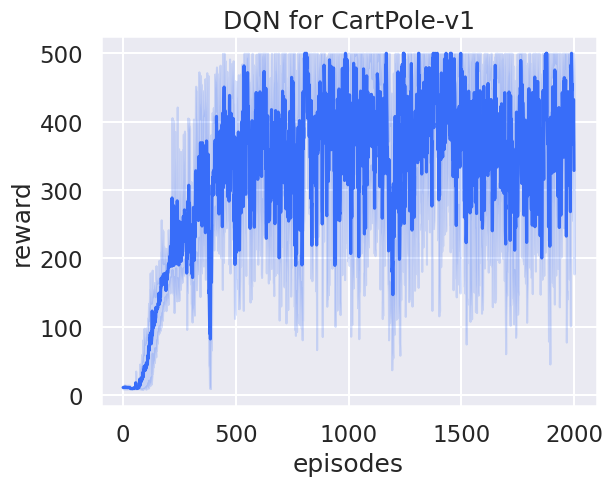

In [21]:
import pandas as pd
import seaborn as sns

rewards_to_plot = [[round(reward, 2) for reward in rewards] for rewards in rewards_over_seeds]

df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="DQN for {}".format(env_name)
)

[Text(0.5, 1.0, 'DQN for CartPole-v1')]

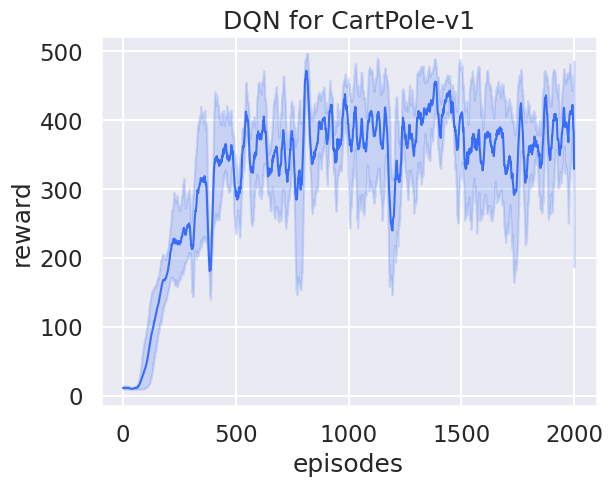

In [22]:
def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

rewards_to_plot = [[round(reward, 2) for reward in rewards] for rewards in rewards_over_seeds]
# print(rewards_to_plot)
for i in range(len(rewards_to_plot)):
  rewards_to_plot[i] = moving_average(rewards_to_plot[i], 19) # 调这里 更改平滑度

df1 = pd.DataFrame(rewards_to_plot).melt()  #  .rolling(window=30).mean()

df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1, linewidth=1.5).set(
    title="DQN for {}".format(env_name)
)   # 调线宽

# CartPole-v1
# 奖励阈值为 500
# 回合长度阈值为 500

在 DQN 的性能得到提升后，它会持续出现一定程度的震荡

这主要是**神经网络过拟合**到一些**局部经验数据**后由 $\arg\max$ 运算带来的影响。

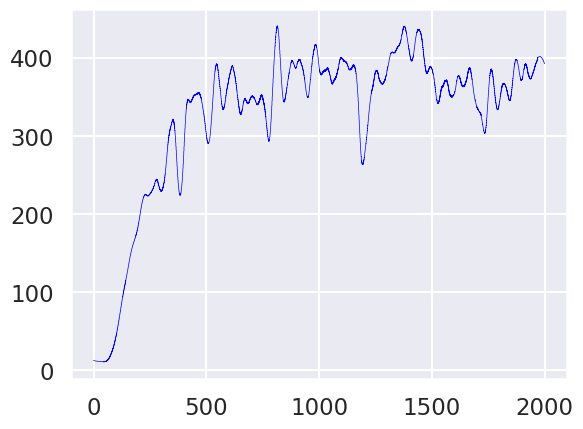

In [23]:
from scipy.signal import savgol_filter
%matplotlib inline

# 应用平滑滤波器
window_size = 300  # 窗口大小，即平滑的程度
polyorder = 2     # 多项式的阶数

# 对 y 值使用 savgol_filter
smoothed_y = savgol_filter(df1['reward'], window_length=window_size, polyorder=polyorder)

# 绘制平滑后的线图
plt.plot(df1['episodes'], smoothed_y, color='blue', linewidth=0.5)   # 2

# 将训练结果 存到 本地， 方便后续进行比较 (DataFrame && csv)


https://pandas.pydata.org/docs/user_guide/10min.html#importing-and-exporting-data

In [24]:
import os
# 查看当前目录
print(os.getcwd())

/content/drive/MyDrive/DQNs-Test


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
%cd /content/drive/MyDrive/DQNs-Test
!ls

# 在 目录 /content/drive/MyDrive 下新建一个文件夹 DQNs-Test

/content/drive/MyDrive/DQNs-Test


In [27]:
DQNs_df = pd.DataFrame(
    {
        "DQN_shangjiao": smoothed_y
    }
)

DQNs_df.to_csv("/content/drive/MyDrive/DQNs-Test/DQNs_df.csv")

In [28]:
my_df_loaded = pd.read_csv('/content/drive/MyDrive/DQNs-Test/DQNs_df.csv', index_col=0)   # index_col=0 指定行索引的位置
my_df_loaded

,DQN_shangjiao
0,11.756439
1,11.742772
2,11.729179
3,11.715661
4,11.702218
...,...
9995,392.713594
9996,392.546265
9997,392.377303
9998,392.206707


# 输入为 图片时拟合 Q 函数的卷积网络

In [29]:
print(YES!)

SyntaxError: invalid syntax (<ipython-input-29-47097660bd32>, line 1)

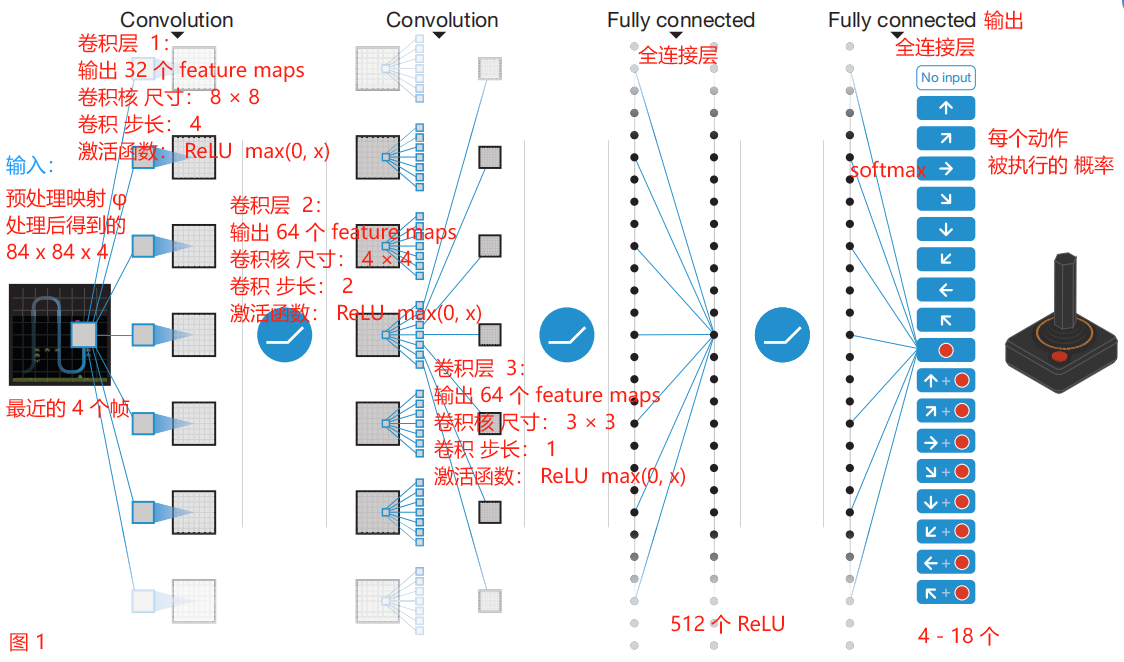

In [ ]:
class ConvolutionalQnet(torch.nn.Module):
  """ 加入 卷积层 的 Q 网络 """
  def __init__(self, action_dim, in_channels=4):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
    self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
    self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
    self.head = torch.nn.Linear(512, action_dim)

  def forward(self, x):
    x = x / 255
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.fc4(x))
    return self.head(x)
